Лабораторна робота №3 “Unsupervised Learning”<br>
з дисципліни "Вступ до машинного навчання"<br>
Виконав:<br>
студент III курсу, групи ДА-22<br>
Клочай Іван Олександрович

# Підготовка до виконання лабораторної роботи

## Імпортування модулів

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import re

## Імпортування даних

In [2]:
# Джерело: https://www.kaggle.com/competitions/titanic
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

## Функції, що знадобляться під час роботи

### Виведення таблиці з кількістю пропущених значень

In [3]:
# Приймає масив DataFrame і виводить таблицю з кількістю пропущених значень для кожного датасету:
def display_missing_values(dataframes: list[tuple[str, pd.DataFrame]]) -> None:
    # Обчислення пропусків для кожного DataFrame
    missing_data_list = []
    for name, dataframe in dataframes:
        missing = dataframe.isnull().sum().reset_index()
        missing.columns = ['Column Name', f'Missing in {name}']
        missing_data_list.append(missing)

    # Послідовне об'єднання результатів
    missing_data = missing_data_list[0]
    for idx in range(1, len(missing_data_list)):
        missing_data = pd.merge(
            missing_data,
            missing_data_list[idx],
            on='Column Name',
            how='outer'
        )

    # Відновлення порядку колонок згідно з першим DataFrame
    column_order = list(dataframes[0][1].columns)
    for _, df in dataframes[1:]:
        column_order += [col for col in df.columns if col not in column_order]

    missing_data['Column Name'] = pd.Categorical(
        missing_data['Column Name'],
        categories = column_order,
        ordered = True
    )
    missing_data = missing_data.sort_values(by = 'Column Name').reset_index(drop = True)

    # Виведення результату
    with pd.option_context('display.max_rows', None):
        display(missing_data)

### Виведення таблиці з кількістю дублікатів

In [4]:
# Приймає масив DataFrame і виводить таблицю з кількістю дублікатів для кожного датасету:
def display_duplicate_counts(dataframes: list[tuple[str, pd.DataFrame]]) -> None:
    duplicate_data_list = []

    # Перебір кожного DataFrame
    for name, dataframe in dataframes:
        duplicate_count = dataframe.duplicated().sum()
        duplicate_data_list.append({'DataFrame': name, 'Duplicate Count': duplicate_count})

    # Перетворення результатів у DataFrame
    duplicate_data = pd.DataFrame(duplicate_data_list)

    # Виведення результату
    with pd.option_context('display.max_rows', None):
        display(duplicate_data)

### Функція для виведення гістограм для категоріальних значень

In [5]:
def plot_categorical_features(data, categorical_features):
    num_features = len(categorical_features)
    ncols = 12  # Кількість графіків в одному рядку
    nrows = (num_features + ncols - 1) // ncols  # Розрахунок кількості рядків

    # Створення фігури та підграфіків
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 2, nrows * 4))
    axes = axes.flatten()  # Перетворення в одновимірний список для зручності ітерації

    # Побудова графіків для кожної змінної
    for i, col in enumerate(categorical_features):
        unique_values = sorted(data[col].dropna().unique())  # Отримання унікальних значень змінної
        
        sns.histplot(
            data=data[col],
            kde=False,
            ax=axes[i],
            discrete=True
        )
        axes[i].set_xlabel('')  # Прибираємо підпис осі X
        axes[i].set_ylabel(col, fontsize=14)  # Додаємо підпис осі Y
        axes[i].set_xticks(unique_values)  # Встановлюємо значення осі X
        axes[i].set_xticklabels([str(val) for val in unique_values], fontsize=14)  # Додаємо підписи

        # Перетворюємо підписи осі Y
        for label in axes[i].get_yticklabels():
            label.set_rotation(60)
            label.set_horizontalalignment('right')

    # Видалення порожніх графіків, якщо їх більше, ніж змінних
    for j in range(num_features, len(axes)):
        fig.delaxes(axes[j])

    # Налаштування щільного розташування
    plt.tight_layout()
    plt.show()

### Функція для виведення гістограм

In [6]:
# Будує гістограми для заданого датасету та колонок:
def plot_histograms(dataframes, columns):
    # Створення підграфіків
    fig, axes = plt.subplots(len(columns) // 3 + 1, 3, figsize=(16, 20))
    axes = axes.flatten()  # Перетворюємо масив осей у плоский список для зручності

    for i, col in enumerate(columns):
        unique_values = dataframes[col].nunique()  # Кількість унікальних значень у колонці
        bins = min(unique_values, 50)  # Встановлюємо кількість бінів (не більше 50)
        dataframes[col].hist(ax=axes[i], bins=bins, color='g', ylabelsize=12)

        # Визначаємо рівномірно розподілені точки для осі X
        min_value, max_value = dataframes[col].min(), dataframes[col].max()
        x_ticks = np.linspace(min_value, max_value, min(unique_values, 10))  # Рівномірно по довжині графіка
        axes[i].set_xticks(x_ticks)
        axes[i].set_xticklabels([str(round(val, 2)) for val in x_ticks], rotation=45, ha='right', fontsize=12)

        axes[i].set_title(col)  # Додаємо назву для кожного графіка

    # Видалення зайвих порожніх підграфіків, якщо їх більше, ніж колонок
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    # Налаштування відображення графіків
    plt.tight_layout()
    plt.show()

### Функція для виведення коробкових графіків

In [7]:
# Будує коробкові графіки для заданого датасету та колонок:
def plot_boxplots(dataframes, columns):
    # Створення підграфіків
    fig, axes = plt.subplots(nrows=len(columns) // 3 + 1, ncols=3, figsize=(20, 40))
    axes = axes.flatten()  # Перетворення масиву осей у плоский список для зручності

    # Побудова boxplot для кожної числової змінної
    for i, col in enumerate(columns):
        sns.boxplot(x=dataframes[col], ax=axes[i])
        axes[i].set_title(col)  # Встановлюємо заголовок для кожного графіка
        axes[i].set_xlabel('')  # Видалення підпису осі X

    # Видалення зайвих порожніх осей, якщо кількість колонок менша за кількість підграфіків
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    # Налаштування відображення графіків
    plt.tight_layout()  # Оптимізація розташування графіків
    plt.show()

### Функція для виведення кластерів

In [8]:
# Візуалізує результати застосування алгоритму кластеризації
def plot_cluster(data, labels, title, dimension_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        data[:, 0], 
        data[:, 1], 
        c=labels, 
        cmap='viridis', 
        s=50
    )
    plt.title(title)
    plt.xlabel(f"{dimension_name}1")
    plt.ylabel(f"{dimension_name}2")
    plt.colorbar(label="Кластер")
    plt.tight_layout()
    plt.show()

# Хід роботи

## Початковий аналіз даних

### Огляд зразків даних

Виведемо кількість значень, колонок та декілька прикладів з файлів "{train|test}.csv":

In [9]:
print(f"Train data:\n{train_data.shape}")
train_data.sample(5)

Train data:
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
314,315,0,2,"Hart, Mr. Benjamin",male,43.0,1,1,F.C.C. 13529,26.2500,NaN,S
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C
73,74,0,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,2680,14.4542,NaN,C
170,171,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,111240,33.5000,B19,S
394,395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S


In [10]:
print(f"Test data:\n{test_data.shape}")
test_data.sample(5)

Test data:
(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
20,912,1,"Rothschild, Mr. Martin",male,55.0,1,0,PC 17603,59.40,NaN,C
196,1088,1,"Spedden, Master. Robert Douglas",male,6.0,0,2,16966,134.50,E34,C
31,923,2,"Jefferys, Mr. Clifford Thomas",male,24.0,2,0,C.A. 31029,31.50,NaN,S
102,994,3,"Foley, Mr. William",male,NaN,0,0,365235,7.75,NaN,Q
78,970,2,"Aldworth, Mr. Charles Augustus",male,30.0,0,0,248744,13.00,NaN,S


### Початкова кількість пропущених значень

In [11]:
display_missing_values([
    ("Train", train_data),
    ("Test", test_data)
])

,Column Name,Missing in Train,Missing in Test
0,PassengerId,0,0.0
1,Survived,0,NaN
2,Pclass,0,0.0
3,Name,0,0.0
4,Sex,0,0.0
5,Age,177,86.0
6,SibSp,0,0.0
7,Parch,0,0.0
8,Ticket,0,0.0
9,Fare,0,1.0


### Початкова кількість дублікатів

In [12]:
display_duplicate_counts([
    ("Train Data", train_data),
    ("Test Data", test_data)
])

,DataFrame,Duplicate Count
0,Train Data,0
1,Test Data,0


### Загальний аналіз значень початкового набору колонок

In [13]:
train_data.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [14]:
test_data.describe(include="all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


## Обробка даних

### Підготовка до первинного видалення колонок

Виведемо значення з колонки 'Survived' в окремий об'єкт:

In [15]:
train_survived = train_data['Survived']

Також виведемо значення 'PassengerId' з тестових даних:

In [16]:
test_id = test_data['PassengerId']

### Видалення зайвих колонок

Видалимо колонки, в яких кількість пропущених значень становить понад 20%:

In [17]:
# Визначаємо поріг пропущених значень
threshold = 0.2  # 20%
columns_to_remove = []

# Знаходимо колонки, в яких відсутньо більше 20% значень
cols_with_many_missing = [
    col for col in train_data.columns
    if train_data[col].isnull().sum() / len(train_data) > threshold
]

# Додаємо знайдені колонки до списку columns_to_remove
columns_to_remove.extend(cols_with_many_missing)

print(f"Колонки з пропущеними значеннями > 20%: {cols_with_many_missing}")
print(f"Оновлений список columns_to_remove: {columns_to_remove}")

Колонки з пропущеними значеннями > 20%: ['Cabin']
Оновлений список columns_to_remove: ['Cabin']


Додамо до масиву колонок, які будуть видалені:<ul>
<li>'PassengerId', що є ідентифікатором пасажиру;</li>
<li>'Ticket', що є ідентифікатором квитка;</li>
<li>'Name' - ім'я та фамілія пасажирів, унікальні значення;</li>
<li>'Survived' - містить результат. Ці дані були виведені в окремий об'єкт;</li>

In [18]:
columns_to_remove.extend([
    'PassengerId',
    'Ticket',
    'Name',
    'Survived',
])

train_data = train_data.drop(columns=columns_to_remove, errors='ignore')
test_data = test_data.drop(columns=columns_to_remove, errors='ignore')

Зробимо перевірку:

In [19]:
print(f"Train data:\n{train_data.shape}")
print(train_data.dtypes.value_counts())
train_data.describe(include="all")

Train data:
(891, 7)
int64      3
object     2
float64    2
Name: count, dtype: int64


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891,714.000000,891.000000,891.000000,891.000000,889
unique,NaN,2,NaN,NaN,NaN,NaN,3
top,NaN,male,NaN,NaN,NaN,NaN,S
freq,NaN,577,NaN,NaN,NaN,NaN,644
mean,2.308642,NaN,29.699118,0.523008,0.381594,32.204208,NaN
std,0.836071,NaN,14.526497,1.102743,0.806057,49.693429,NaN
min,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,2.000000,NaN,20.125000,0.000000,0.000000,7.910400,NaN
50%,3.000000,NaN,28.000000,0.000000,0.000000,14.454200,NaN
75%,3.000000,NaN,38.000000,1.000000,0.000000,31.000000,NaN


In [20]:
print(f"Test data:\n{test_data.shape}")
print(test_data.dtypes.value_counts())
test_data.describe(include="all")

Test data:
(418, 7)
int64      3
object     2
float64    2
Name: count, dtype: int64


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,418.000000,418,332.000000,418.000000,418.000000,417.000000,418
unique,NaN,2,NaN,NaN,NaN,NaN,3
top,NaN,male,NaN,NaN,NaN,NaN,S
freq,NaN,266,NaN,NaN,NaN,NaN,270
mean,2.265550,NaN,30.272590,0.447368,0.392344,35.627188,NaN
std,0.841838,NaN,14.181209,0.896760,0.981429,55.907576,NaN
min,1.000000,NaN,0.170000,0.000000,0.000000,0.000000,NaN
25%,1.000000,NaN,21.000000,0.000000,0.000000,7.895800,NaN
50%,3.000000,NaN,27.000000,0.000000,0.000000,14.454200,NaN
75%,3.000000,NaN,39.000000,1.000000,0.000000,31.500000,NaN


### Перетворення категоріальних змінних

Спочатку виведемо кількості колонок за типами. Визначимо, які саме є категоріальними. Зберемо унікальні значення для цих колонок.

In [21]:
# Підрахунок кількості колонок за типами
print(train_data.dtypes.value_counts())

# Фільтрація колонок типу 'object'
object_columns = train_data.select_dtypes(include=['object']).columns

print("\nКолонки типу 'object':")
print(object_columns.tolist())

# Виведення унікальних значень для кожної колонки типу 'object'
print("\nУнікальні значення в колонках типу 'object':")
for col in object_columns:
    unique_values = train_data[col].unique()
    print(f"Колонка: {col}")
    print(f"Унікальні значення: {unique_values}\n")

int64      3
object     2
float64    2
Name: count, dtype: int64

Колонки типу 'object':
['Sex', 'Embarked']

Унікальні значення в колонках типу 'object':
Колонка: Sex
Унікальні значення: ['male' 'female']

Колонка: Embarked
Унікальні значення: ['S' 'C' 'Q' nan]



Проаналізувавши опис, зазначений у джерелі датасетів, 'Pclass' також є категоріальною колонкою, що має ординальний тип.

Категоріальні змінні 'Sex' та 'Embarked' є неординальними. Оскільки в колонці Embarked не вистачає 2 значення - дозаповнимо її модою і застосуємо для категоріальних змінних метод One-Hot encoding:

In [22]:
categorical_unordinal = [
    'Sex',
    'Embarked',
]

train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

# Замінюємо пробіли на підкреслення, видаляємо спеціальні символи, переводимо у нижній регістр
def clean_category(value):
    if pd.isna(value):
        return value
    return re.sub(r'[^a-zA-Z0-9_]', '', str(value).replace(' ', '_')).lower()

# Застосовуємо дану функцію для усіх колонок для уникнення потенційних проблем з новоутвореними назвами
for col in categorical_unordinal:
    if col in train_data.columns:
        train_data[col] = train_data[col].apply(clean_category)
    if col in test_data.columns:
        test_data[col] = test_data[col].apply(clean_category)

train_existing_columns = set(train_data.columns)
test_existing_columns = set(test_data.columns)

train_data = pd.get_dummies(train_data, columns=categorical_unordinal)
test_data = pd.get_dummies(test_data, columns=categorical_unordinal)

# Визначаємо новоутворені колонки
train_new_columns = set(train_data.columns) - train_existing_columns
test_new_columns = set(test_data.columns) - test_existing_columns

Перевіримо нові колонки на збіжність. Якщо в якихось датасетах їх не вистачає - додамо:

In [23]:
# Додаємо колонки, яких не вистачає в test_data, із значенням 0
for col in train_new_columns:
    if col not in test_data.columns:
        test_data[col] = 0
        test_new_columns.add(col)

# Додаємо колонки, яких не вистачає в train_data, із значенням 0
for col in test_new_columns:
    if col not in train_data.columns:
        train_data[col] = 0
        train_new_columns.add(col)

# Перевіряємо, що тепер обидва DataFrame мають однакові колонки
assert set(train_data.columns) == set(test_data.columns), "Колонки не збігаються!"

Перетворимо типи для новоутворених колонок:

In [24]:
for col in train_new_columns:
    try:
        train_data[col] = train_data[col].astype('int64')
    except ValueError:
        train_data[col] = train_data[col].astype('float64')

    try:
        test_data[col] = test_data[col].astype('int64')
    except ValueError:
        test_data[col] = test_data[col].astype('float64')

Перевіримо результати:

In [25]:
print(f"Train data:\n{train_data.shape}")
print(train_data.dtypes.value_counts())
train_data.describe(include="all")

Train data:
(891, 10)
int64      8
float64    2
Name: count, dtype: int64


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_c,Embarked_q,Embarked_s
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413,0.647587,0.188552,0.086420,0.725028
std,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,0.477990,0.391372,0.281141,0.446751
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
print(f"Test data:\n{test_data.shape}")
print(test_data.dtypes.value_counts())
test_data.describe(include="all")

Test data:
(418, 10)
int64      8
float64    2
Name: count, dtype: int64


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_c,Embarked_q,Embarked_s
count,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188,0.363636,0.636364,0.244019,0.110048,0.645933
std,0.841838,14.181209,0.896760,0.981429,55.907576,0.481622,0.481622,0.430019,0.313324,0.478803
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,27.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,39.000000,1.000000,0.000000,31.500000,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


### Дозаповнення даних

Тепер розділимо категоріальні та числові змінні:

In [27]:
categorical_features = []
numerical_features = []

for col in train_data.columns:
    # Якщо унікальних значень менше 6
    if len(train_data[col].dropna().unique()) <= 6:
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"Кількість категоріальних колонок: {len(categorical_features)}")
print("Категоріальні колонки:", categorical_features)

print(f"\nКількість числових колонок: {len(numerical_features)}")
print("Числові колонки:", numerical_features)

Кількість категоріальних колонок: 6
Категоріальні колонки: ['Pclass', 'Sex_female', 'Sex_male', 'Embarked_c', 'Embarked_q', 'Embarked_s']

Кількість числових колонок: 4
Числові колонки: ['Age', 'SibSp', 'Parch', 'Fare']


Оцінімо кількість пропущених значень:

In [28]:
display_missing_values([
    ("Train categorical", train_data[categorical_features]),
    ("Test categorical", test_data[categorical_features]),
])
display_missing_values([
    ("Train numerical", train_data[numerical_features]),
    ("Test numerical", test_data[numerical_features]),
])

,Column Name,Missing in Train categorical,Missing in Test categorical
0,Pclass,0,0
1,Sex_female,0,0
2,Sex_male,0,0
3,Embarked_c,0,0
4,Embarked_q,0,0
5,Embarked_s,0,0


,Column Name,Missing in Train numerical,Missing in Test numerical
0,Age,177,86
1,SibSp,0,0
2,Parch,0,0
3,Fare,0,1


Отримуємо, що серед числових колонок з пропущеними значеннями, крім віку, є параметр 'Fare' з одним пропуском. Заповнимо пропуски за допомогою медіани:

In [29]:
for col in numerical_features:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

Перевірка:

In [30]:
display_missing_values([
    ("Train numerical", train_data[numerical_features]),
    ("Test numerical", test_data[numerical_features]),
])

,Column Name,Missing in Train numerical,Missing in Test numerical
0,Age,0,0
1,SibSp,0,0
2,Parch,0,0
3,Fare,0,0


## Візуалізація даних

### Графіки категоріальних даних

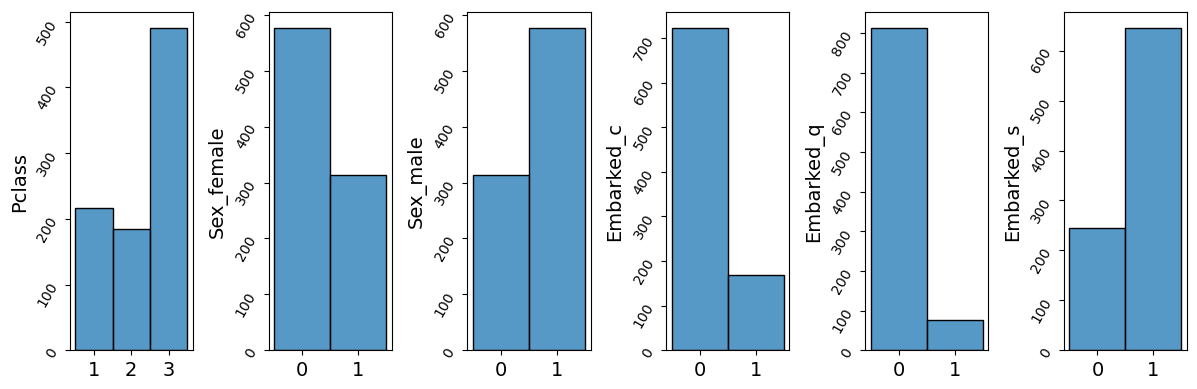

In [31]:
plot_categorical_features(train_data, categorical_features)

### Графіки числових даних

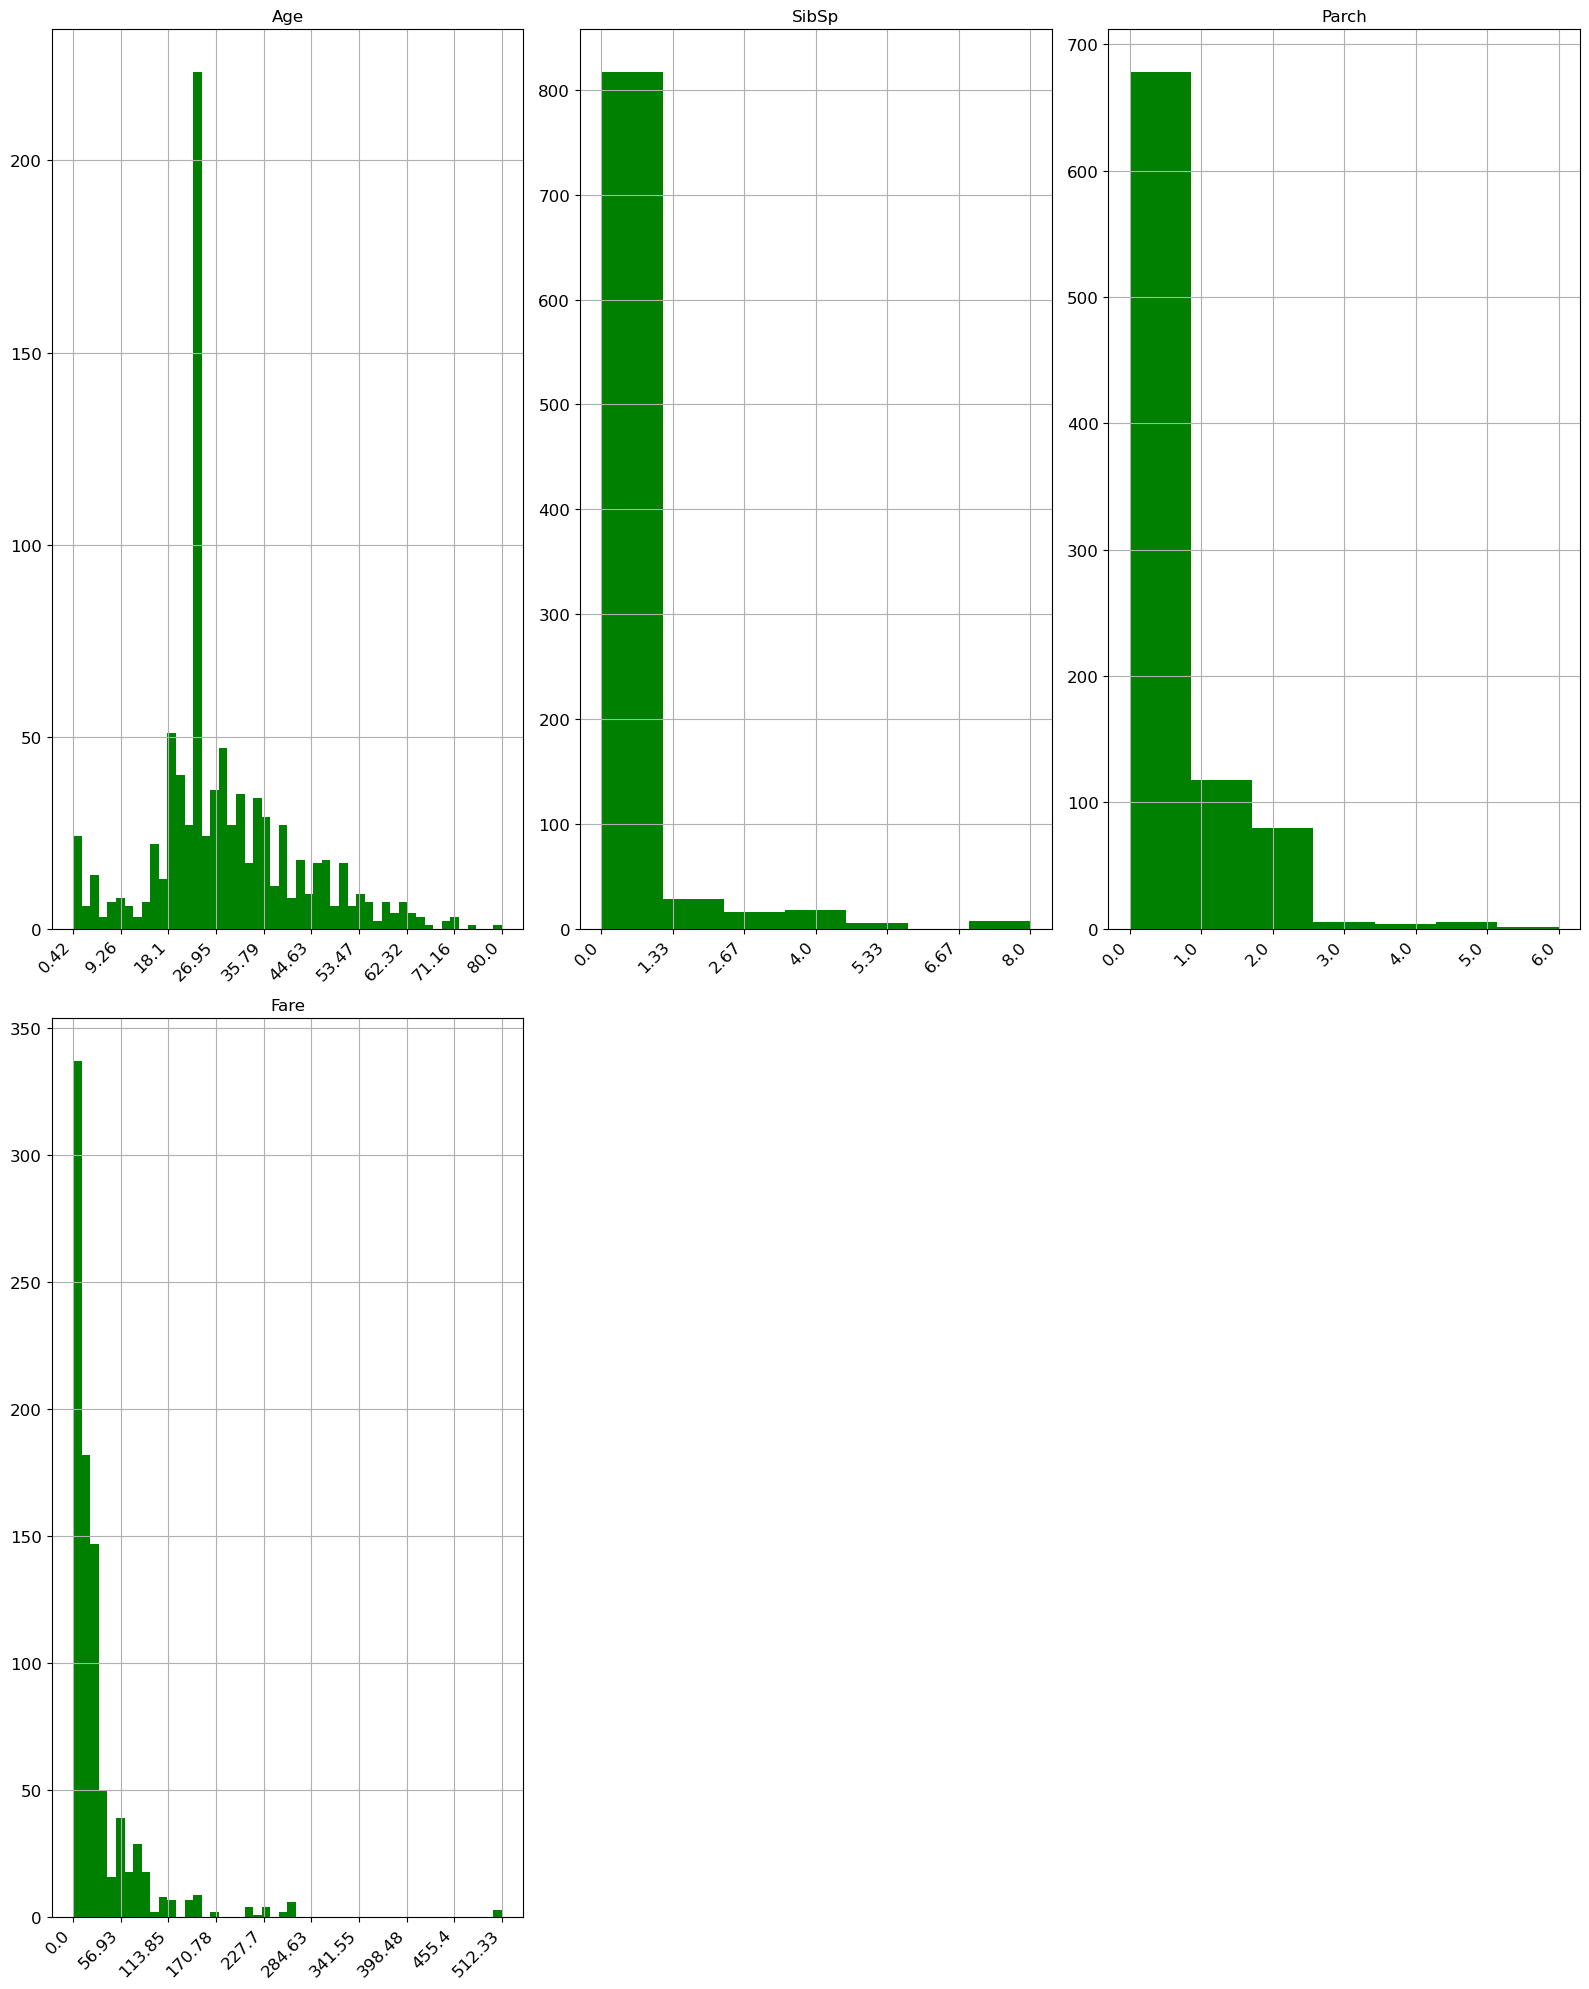

In [32]:
plot_histograms(train_data, numerical_features)

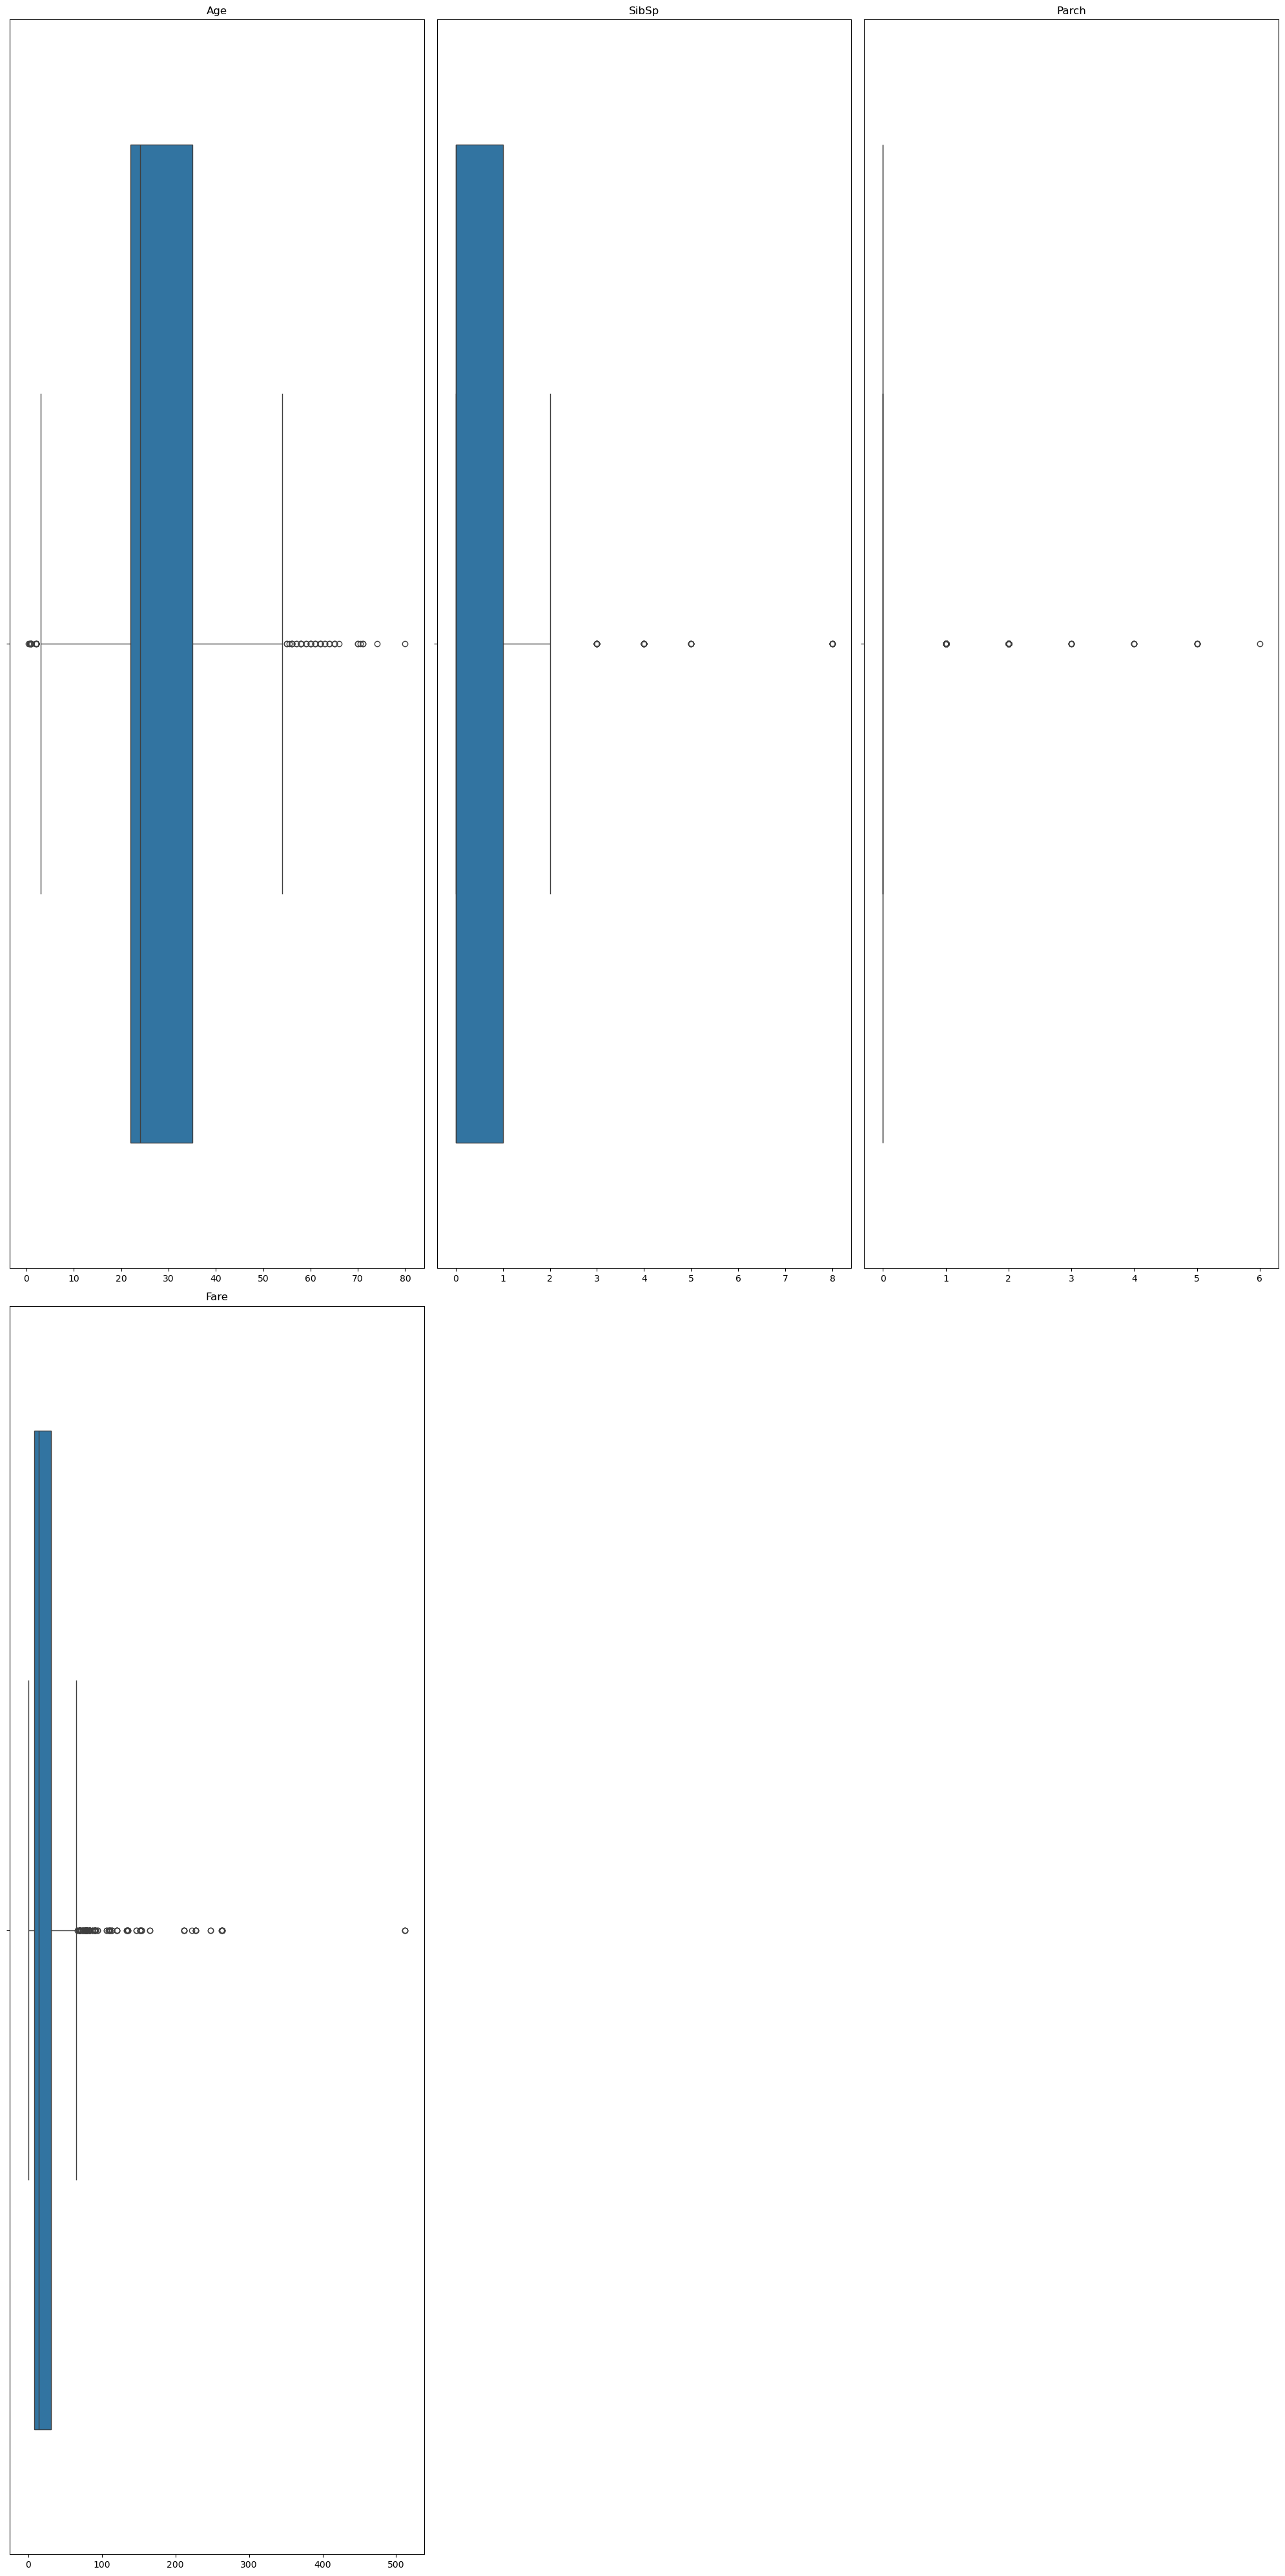

In [33]:
plot_boxplots(train_data, numerical_features)

### Розподіл цільової змінної

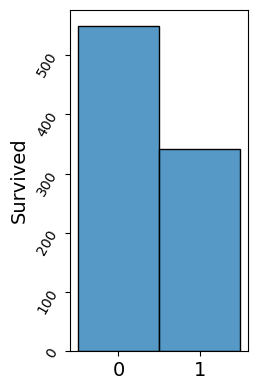

In [34]:
plot_categorical_features(train_survived.to_frame(name='Survived'), ['Survived'])

### Матриця кореляцій

<Axes: >

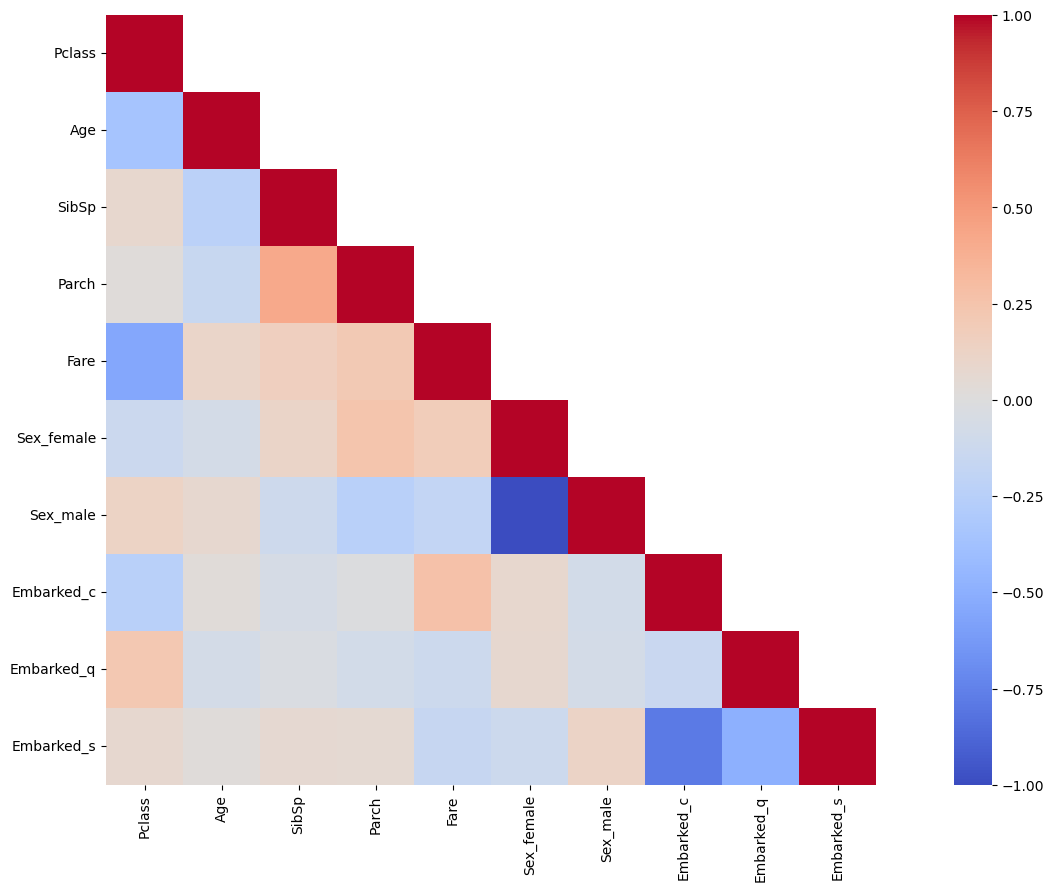

In [35]:
corrMatt = train_data.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask, cmap="coolwarm", square=True, vmin=-1, vmax=1)

## Кластеризація даних

In [36]:
from sklearn.preprocessing import StandardScaler

X = train_data.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components = 2, perplexity = 50, random_state = 42)
X_tsne = tsne.fit_transform(X_scaled)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


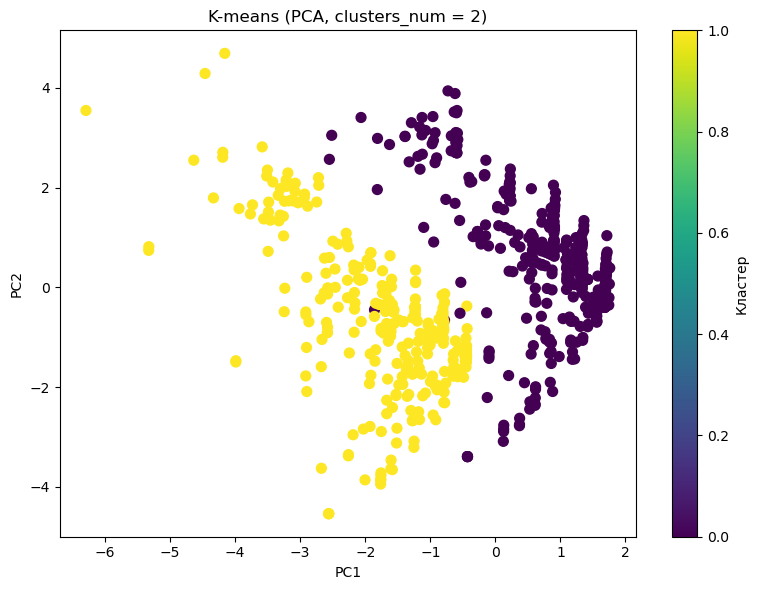

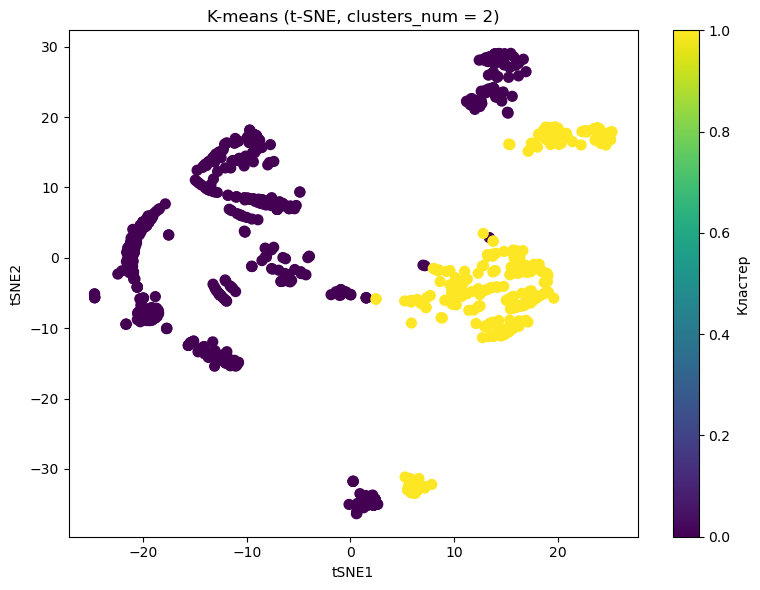

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


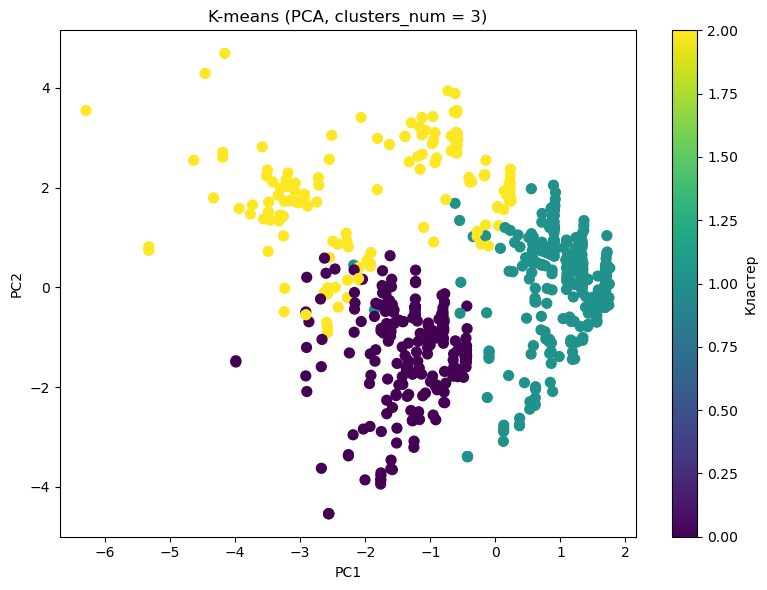

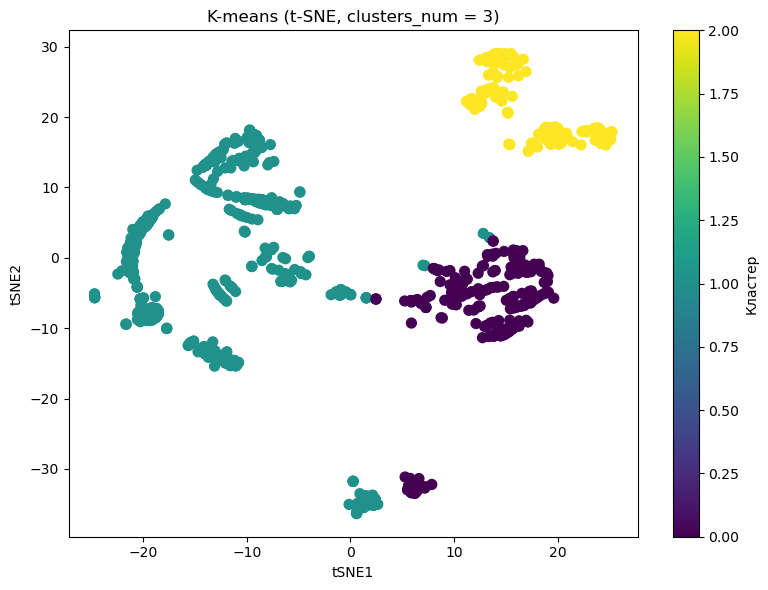

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


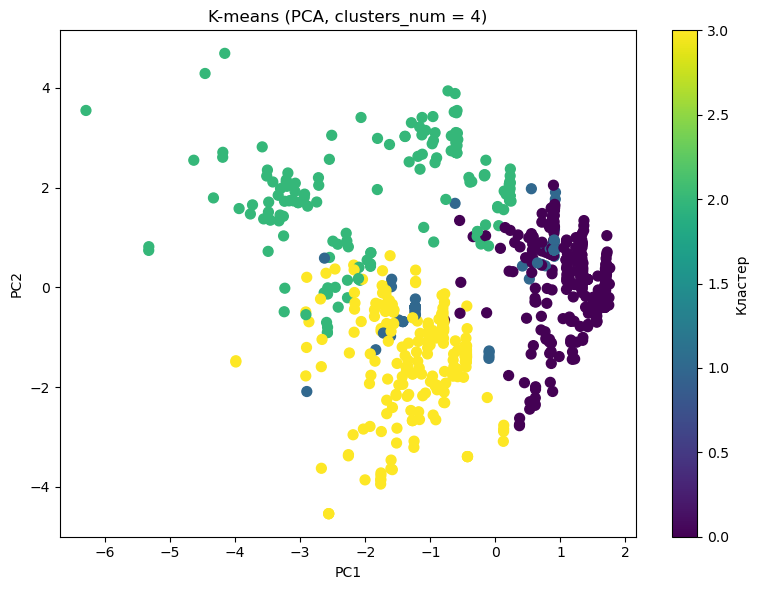

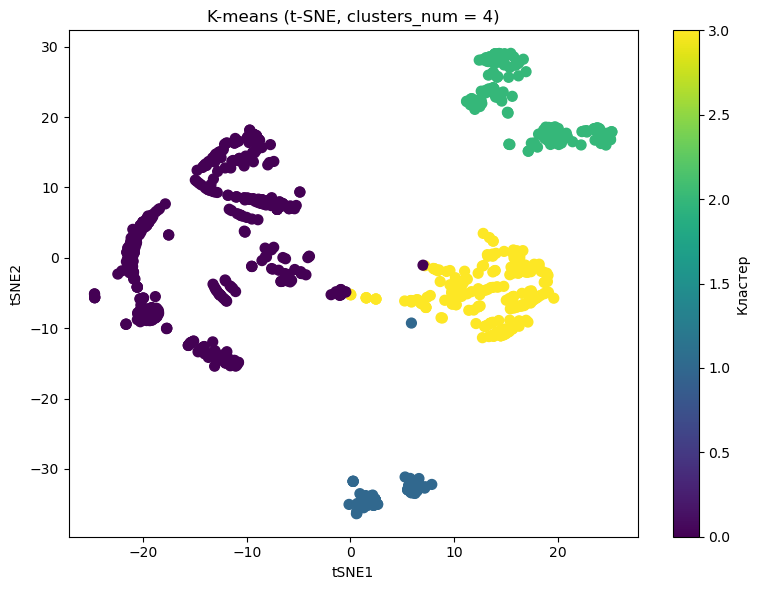

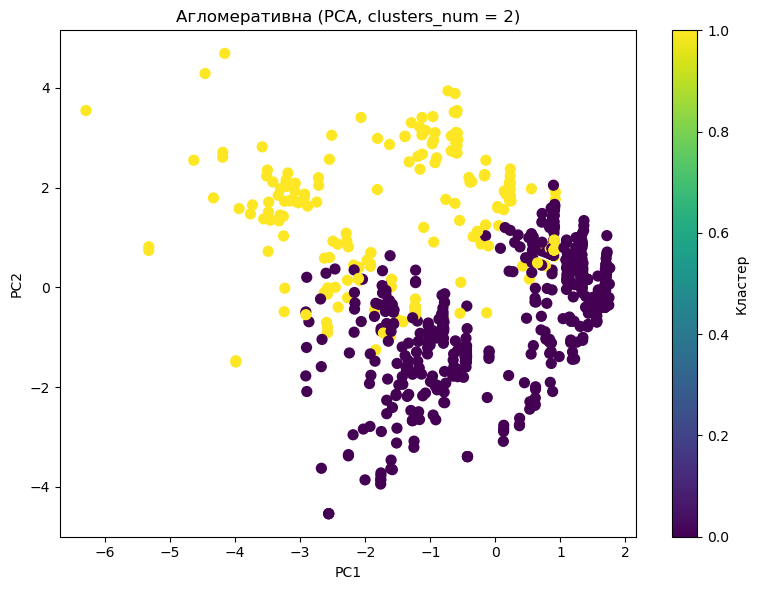

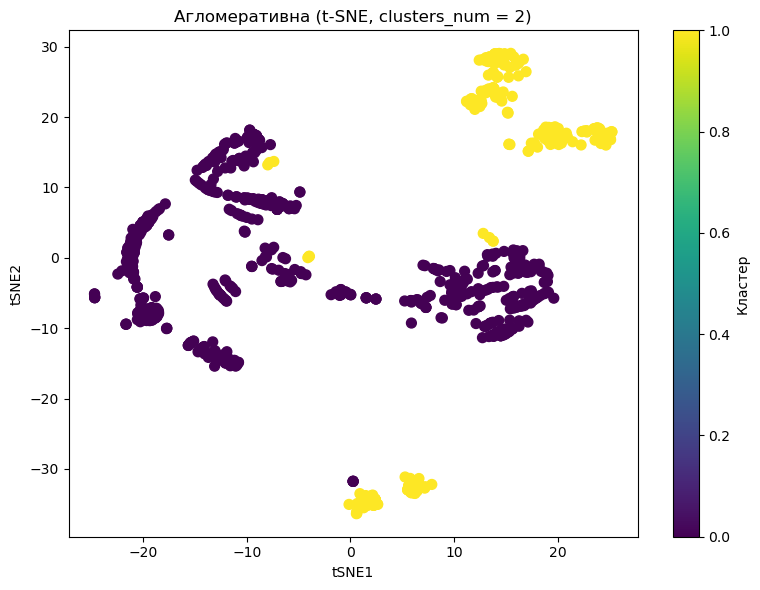

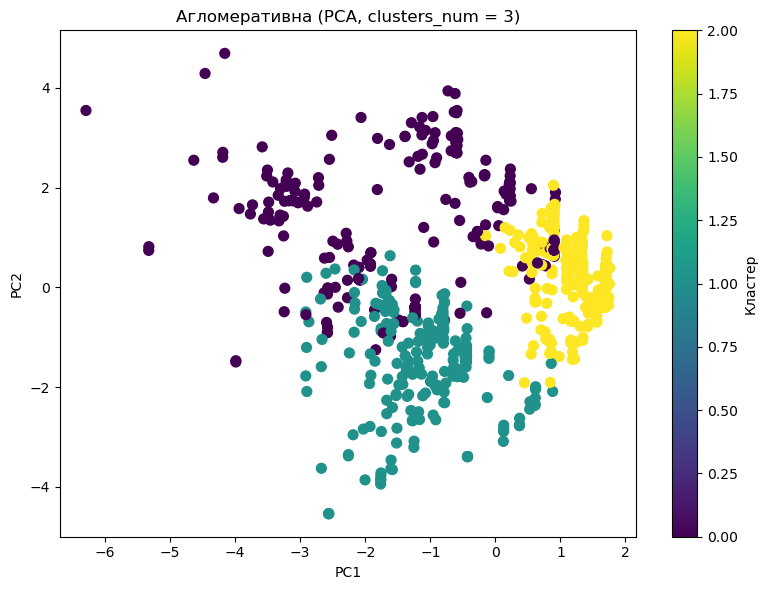

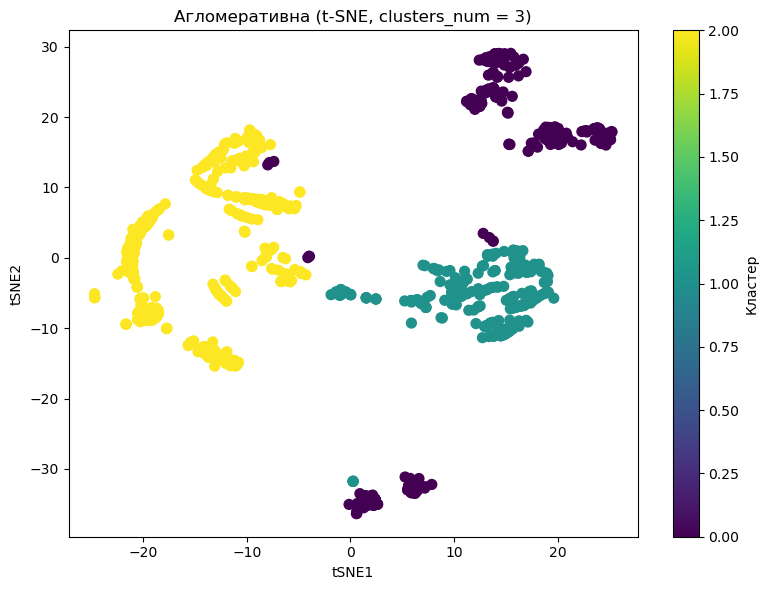

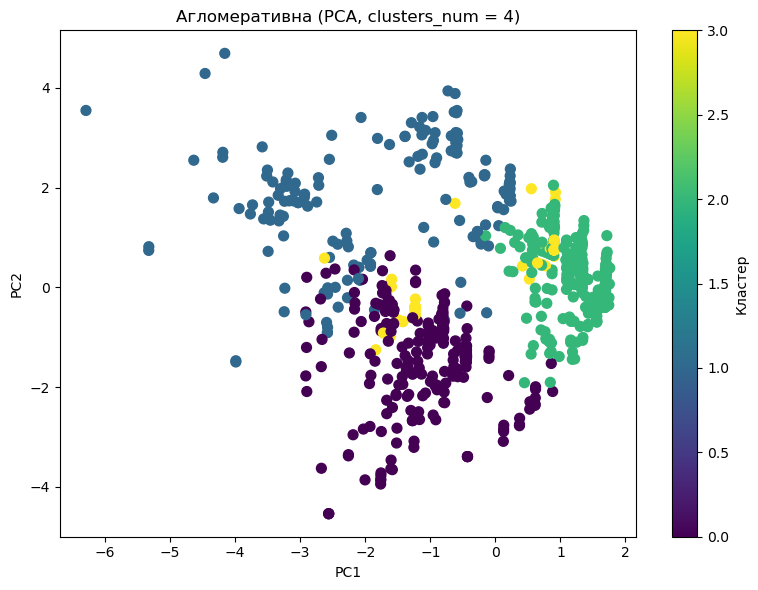

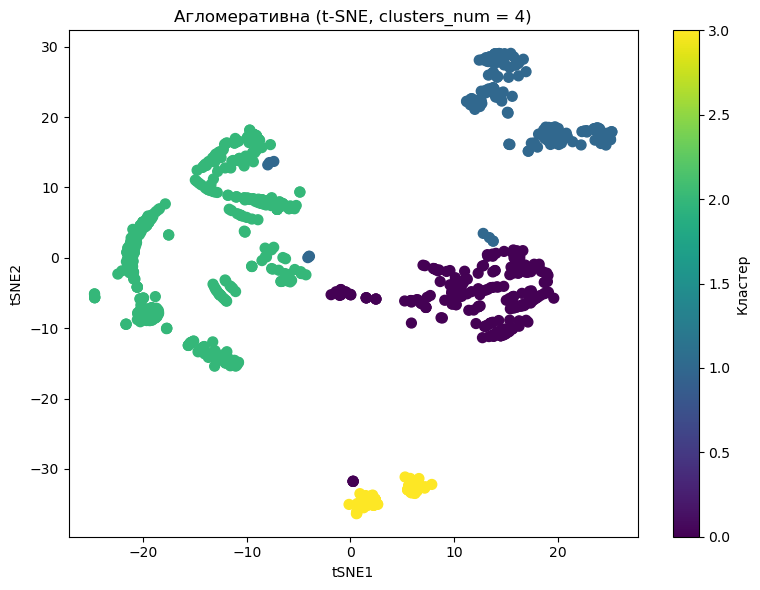

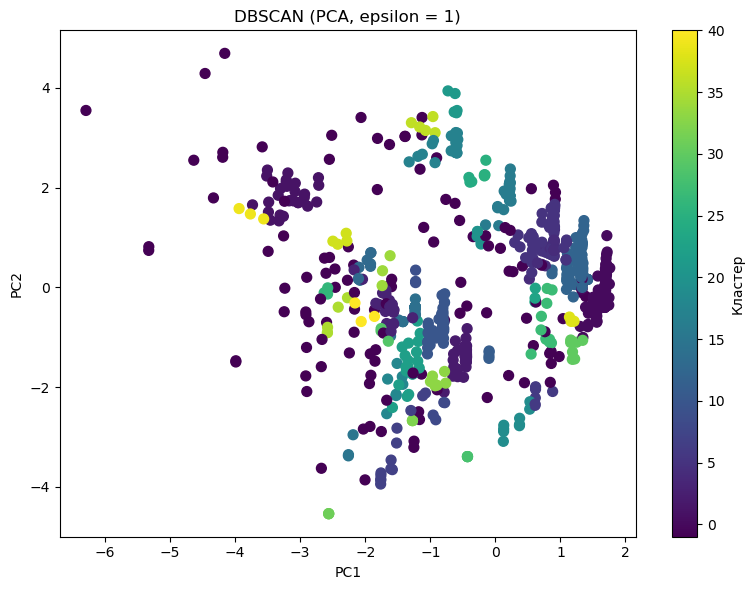

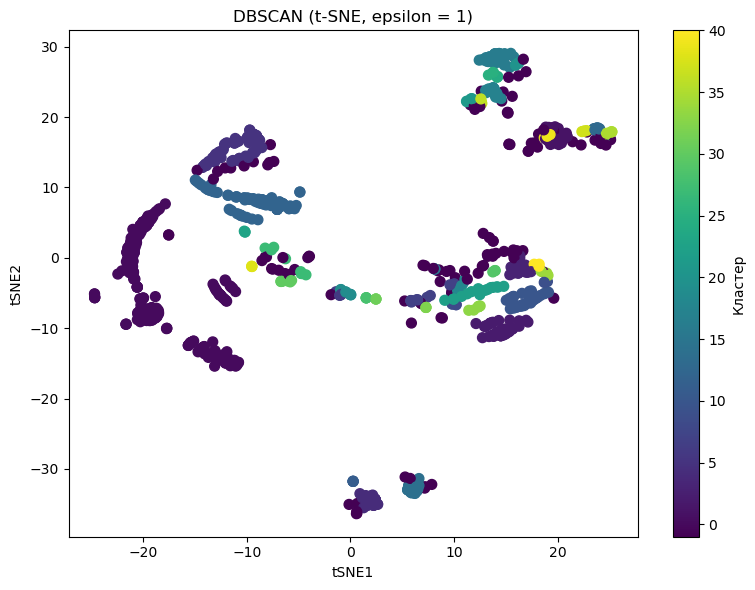

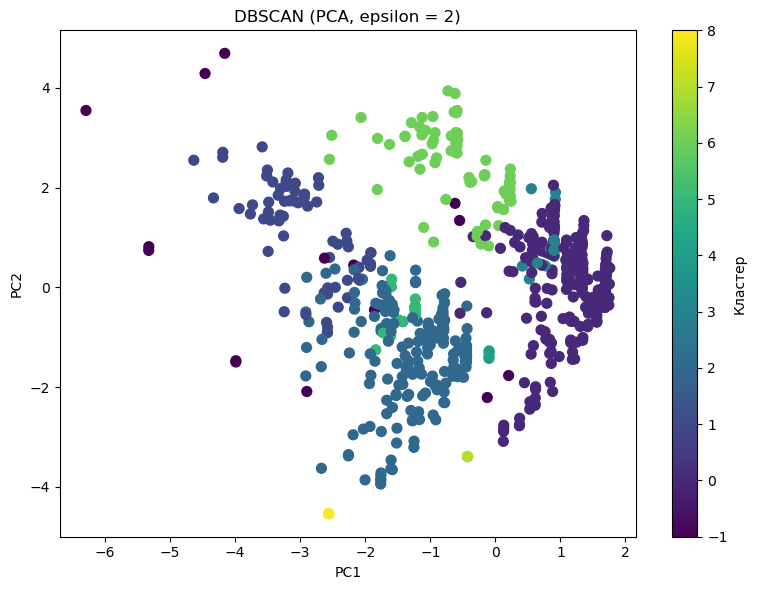

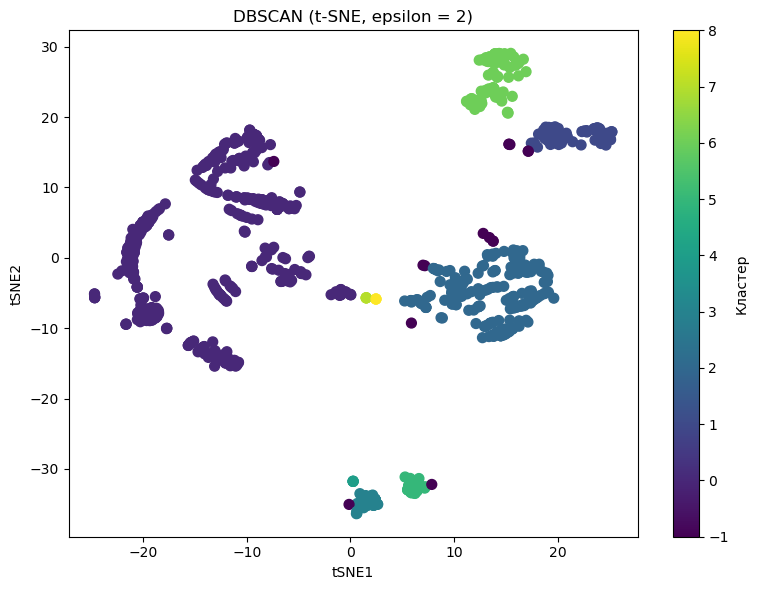

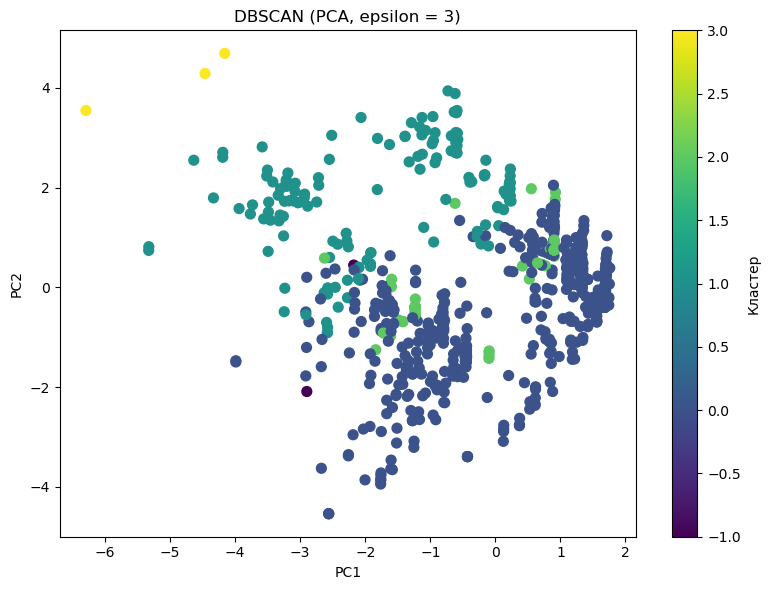

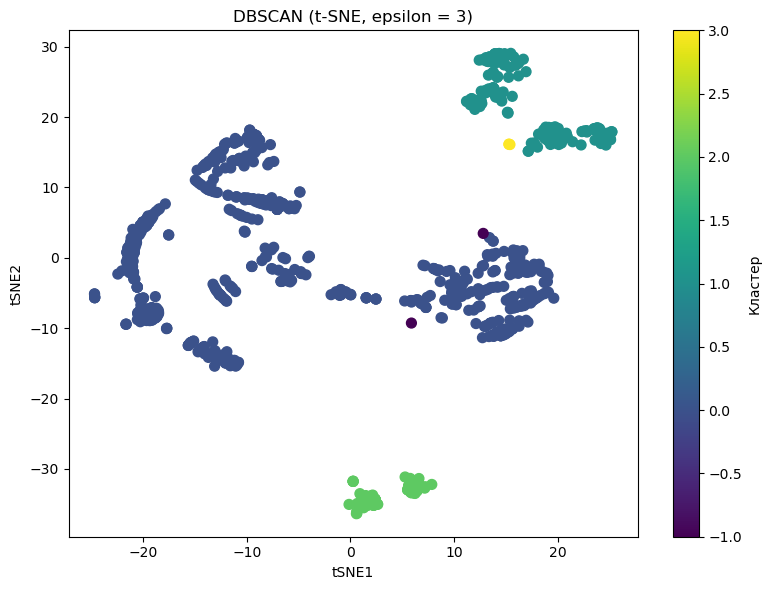

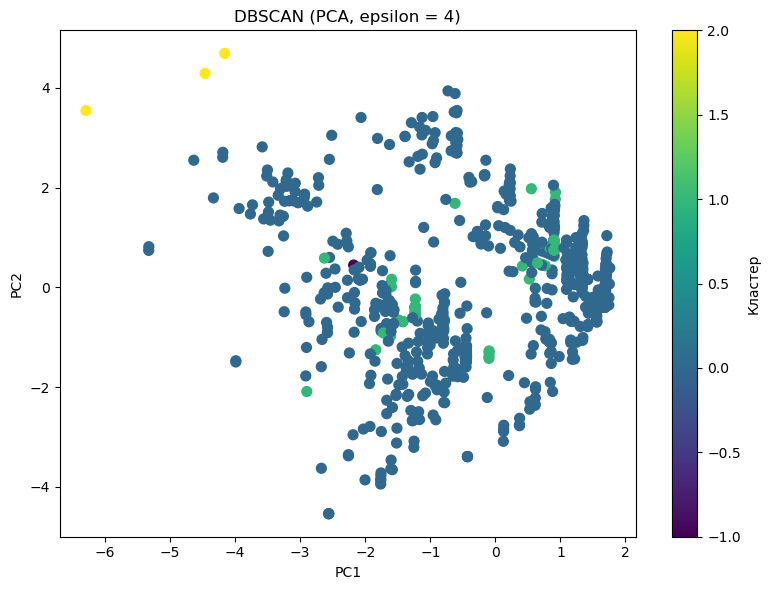

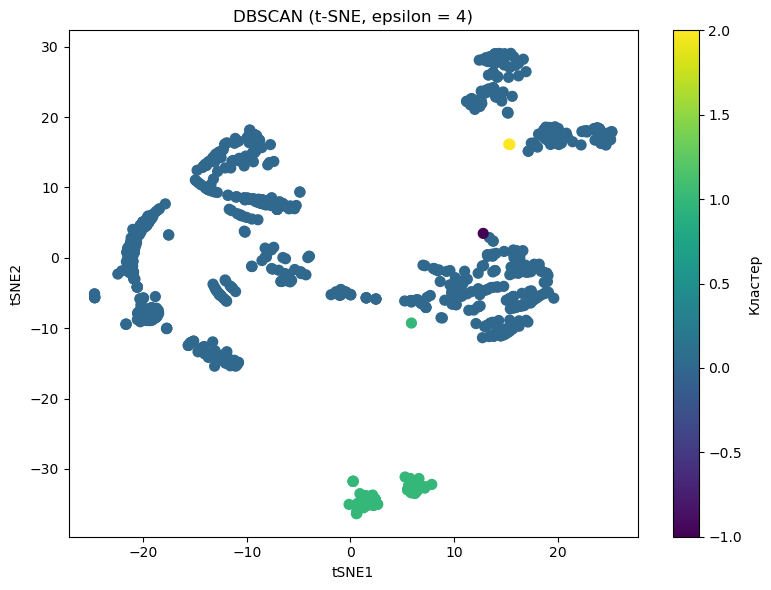

In [38]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

for clusters_num in range(2, 5):
    kmeans_model = KMeans(
        n_clusters = clusters_num,
        random_state = 10,
        n_init = 10
    )
    kmeans_labels = kmeans_model.fit_predict(X_scaled)
    plot_cluster(X_pca, kmeans_labels, f"K-means (PCA, clusters_num = {clusters_num})", "PC")
    plot_cluster(X_tsne, kmeans_labels, f"K-means (t-SNE, clusters_num = {clusters_num})", "tSNE")

for clusters_num in range(2, 5):
    agglomerative_model = AgglomerativeClustering(
        n_clusters = clusters_num,
    )
    agglomerative_labels = agglomerative_model.fit_predict(X_scaled)
    plot_cluster(X_pca, agglomerative_labels, f"Агломеративна (PCA, clusters_num = {clusters_num})", "PC")
    plot_cluster(X_tsne, agglomerative_labels, f"Агломеративна (t-SNE, clusters_num = {clusters_num})", "tSNE")

for epsilon in range(1, 5):
    dbscan_model = DBSCAN(
        eps = epsilon,
        min_samples = 3,
    )
    dbscan_labels = dbscan_model.fit_predict(X_scaled)
    plot_cluster(X_pca, dbscan_labels, f"DBSCAN (PCA, epsilon = {epsilon})", "PC")
    plot_cluster(X_tsne, dbscan_labels, f"DBSCAN (t-SNE, epsilon = {epsilon})", "tSNE")